In [1]:
import pandas as pd
import json
import requests
from pprint import pprint
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

***

# FSP maps

** Type_id, colors, and number of points **

All types

```sql
SELECT iso, sector, type, type_id, color, count(*) as number_of_points
FROM fsp_maps
GROUP BY iso, sector, type, type_id, color
ORDER BY iso, sector, type, type_id, color
```

Selected types

```sql
SELECT iso, sector, type, type_id, color, count(*) as number_of_points
FROM fsp_maps
WHERE iso = 'KEN' and sector = 'Agriculture' and type in ('Agro-Dealers', 'Market Locations')
GROUP BY iso, sector, type, type_id, color
ORDER BY iso, sector, type, type_id, color
```

***

# FSP layers

## Points

** Query **

```sql
SELECT the_geom, iso, sector, type FROM fsp_maps
WHERE type_id in (40,51,58,62,67)
```

** CSS **

```css
#layer {
  marker-width: 7;
  marker-fill: #EE4D5A;
  marker-fill-opacity: 0.9;
  marker-line-color: #FFFFFF;
  marker-line-width: 1;
  marker-line-opacity: 1;
  marker-placement: point;
  marker-type: ellipse;
  marker-allow-overlap: true;
}
```

## Heat map

** Query **

```sql
SELECT the_geom FROM fsp_maps
WHERE type_id = 40
```

```css
Map {
  -torque-frame-count: 1;
  -torque-animation-duration: 30;
  -torque-time-attribute: "cartodb_id";
  -torque-aggregation-function: "count(1)";
  -torque-resolution: 4;
  -torque-data-aggregation: linear;
}
#layer {
  marker-width: 25;
  marker-fill: white;
  marker-fill-opacity: 1;
  marker-file: url(https://cartodb-libs.global.ssl.fastly.net/cartodbui/assets/unversioned/images/alphamarker.png);
  marker-allow-overlap: true;
  marker-line-width: 1;
  marker-line-color: #FFFFFF;
  marker-line-opacity: 1;
  image-filters: colorize-alpha(#4b2991,#932da3,#d43f96,#f7667c,#f89f77,#edd9a3);
}
```

** CSS **

## Voronoid

** Query **

```sql
WITH v as (SELECT v.*, m.type, m.type_id
             FROM fsp_voronoid as v
        LEFT JOIN fsp_maps as m
               ON v.id = m.id 
         ORDER BY v.id)
            
SELECT the_geom
FROM v
WHERE type_id = 40
```

*** 

# Contextual layers

** Layers' name **

```sql
SELECT layer FROM layer_spec
```

## From Carto 

** Query and CSS **

```sql
SELECT queries, css FROM layer_spec WHERE layer = 'AidData'
```

## From RW API

** Layer id **

```sql
SELECT layer_id FROM layer_spec WHERE layer = 'Accessibility to Cities'
```

***

# FSP maps analysis

## Country information
** Total, urban, and rural population, their percentages, and population within 5 km of all access points**

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'KEN'),
     u as (SELECT u.the_geom FROM urban_areas as u
             JOIN world_borders_hd as b
               ON ST_Intersects(b.the_geom, u.the_geom)
            WHERE b.iso_a3 = 'KEN')

SELECT tot.pop as total_population, urb.pop as urban_population, 
  round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as 
  rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as   
  rural_population_percentage, round(pop_km.tot_pop_km::numeric) as population_5km,
  round(((round(pop_km.tot_pop_km::numeric)/tot.pop)*100)::numeric, 1) as population_5km_percentage,
  2015 as year
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb,
     (SELECT total_population as tot_pop_km
        FROM population_within_5km 
       WHERE iso = 'KEN'
      ) as pop_km
```

widget_config

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b WHERE b.iso_a3 = 'KEN'), u as (SELECT u.the_geom FROM urban_areas as u JOIN world_borders_hd as b ON ST_Intersects(b.the_geom, u.the_geom) WHERE b.iso_a3 = 'KEN') SELECT tot.pop as total_population, urb.pop as urban_population, round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as rural_population_percentage, round(pop_km.tot_pop_km::numeric) as population_5km, round(((round(pop_km.tot_pop_km::numeric)/tot.pop)*100)::numeric, 1) as population_5km_percentage, 2015 as year FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop FROM population_count_2015, b WHERE ST_Intersects(the_raster_webmercator, b.the_geom)) as tot, (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop FROM population_count_2015, u WHERE ST_Intersects(the_raster_webmercator, u.the_geom)) as urb,(SELECT total_population as tot_pop_km FROM population_within_5km WHERE iso = 'KEN') as pop_km
```

In [68]:
json.dumps({'widgetConfig': {'sql_config': [{'key': 'where',
       'key_params': [{'key': 'iso_a3', 'required': False}]}],
      'sql_query': 'with r as (SELECT the_geom, sum(transaction_value) as total_transaction_value  FROM aiddata_transactions {{where}} GROUP BY the_geom) SELECT CDB_JenksBins(array_agg(total_transaction_value::numeric),5) as bucket FROM r WHERE total_transaction_value is not null',
      'type': 'text'}})

'{"widgetConfig": {"sql_config": [{"key": "where", "key_params": [{"key": "iso_a3", "required": false}]}], "sql_query": "with r as (SELECT the_geom, sum(transaction_value) as total_transaction_value  FROM aiddata_transactions {{where}} GROUP BY the_geom) SELECT CDB_JenksBins(array_agg(total_transaction_value::numeric),5) as bucket FROM r WHERE total_transaction_value is not null", "type": "text"}}'

## Nearby Polygon
** We use this [API](https://openrouteservice.org/documentation/#/reference/isochrones/isochrones/isochrones-service) to get the geometries **

Example url:
```html
https://api.openrouteservice.org/isochrones?api_key=your-api-key&locations=8.34234%2C48.23424&profile=driving-car&range_type=time&range=60&interval=&units=m&location_type=start&attributes=&options=&intersections=&id=
```

In [12]:
api_key = '5b3ce3597851110001cf6248ce35abcdfc0547a283c2b4ab7e581dd8'
lng = '36.815185546875'
lat = '-1.282546686897245'
profile = 'foot-walking'
range = 2000 #Maximum range value of the analysis in seconds. 

url = f"https://api.openrouteservice.org/isochrones?api_key={api_key}&locations={lng}%2C{lat}&profile={profile}&range_type=time&range={range}"

r = requests.get(f"{url}")

Point

In [13]:
r.json().get('features')[0].get('properties').get('center')

[36.815186, -1.282547]

Polygon

In [14]:
json.dumps(r.json().get('features')[0].get('geometry'), separators=(',',':'))

'{"type":"Polygon","coordinates":[[[36.793497,-1.276439],[36.795092,-1.28584],[36.795113,-1.289178],[36.796803,-1.295043],[36.797672,-1.296449],[36.800558,-1.299214],[36.801495,-1.29994],[36.811105,-1.303825],[36.812905,-1.303719],[36.824329,-1.305852],[36.827847,-1.30312],[36.82811,-1.302775],[36.829646,-1.29959],[36.834238,-1.290449],[36.836323,-1.289074],[36.837129,-1.287775],[36.838203,-1.285111],[36.838232,-1.284935],[36.837288,-1.277239],[36.835418,-1.268669],[36.83278,-1.265343],[36.832401,-1.265428],[36.82608,-1.265214],[36.818695,-1.258269],[36.818625,-1.258239],[36.818611,-1.258233],[36.817966,-1.25796],[36.811114,-1.259599],[36.799968,-1.261126],[36.799954,-1.26113],[36.795923,-1.269467],[36.795084,-1.271342],[36.79378,-1.27427],[36.793497,-1.276439]]]}'

## Information
** Total selected access points and population **

Polygon 

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.1834716796875,-1.7465556193132534],[37.5238037109375,-1.7465556193132534],[37.5238037109375,-0.8459165322899671],[36.1834716796875,-0.8459165322899671],[36.1834716796875,-1.7465556193132534]]]}'),4326) as the_geom),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u, b
           WHERE ST_Intersects(u.the_geom, b.the_geom))

SELECT points.count as access_points, tot.pop as total_population, COALESCE(urb.pop, tot.pop) as urban_population, 
  round(((COALESCE(urb.pop, tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - COALESCE(urb.pop, tot.pop)) as 
  rural_population, round((((tot.pop - COALESCE(urb.pop, tot.pop))/tot.pop)*100)::numeric,1) as   
  rural_population_percentage
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb,
    (SELECT count(*)
        FROM fsp_maps as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom) and type_id in (40,51,58,62,67)
     ) as points
```

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'KEN'),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u
             JOIN world_borders_hd as b
               ON ST_Intersects(b.the_geom, u.the_geom)
            WHERE b.iso_a3 = 'KEN')

SELECT points.count as access_points, tot.pop as total_population, urb.pop as urban_population, 
  round(((urb.pop/tot.pop)*100)::numeric, 1) as urban_population_percentage, (tot.pop - urb.pop) as 
  rural_population, round((((tot.pop - urb.pop)/tot.pop)*100)::numeric,1) as   
  rural_population_percentage
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb,
    (SELECT count(*)
        FROM fsp_maps
       WHERE type_id in (40,51,58,62,67)
     ) as points
```

## Charts

** Number of services **

Polygon (Nearby)

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.793497,-1.276439],[36.795092,-1.28584],[36.795113,-1.289178],[36.796803,-1.295043],[36.797672,-1.296449],[36.800558,-1.299214],[36.801495,-1.29994],[36.811105,-1.303825],[36.812905,-1.303719],[36.824329,-1.305852],[36.827847,-1.30312],[36.82811,-1.302775],[36.829646,-1.29959],[36.834238,-1.290449],[36.836323,-1.289074],[36.837129,-1.287775],[36.838203,-1.285111],[36.838232,-1.284935],[36.837288,-1.277239],[36.835418,-1.268669],[36.83278,-1.265343],[36.832401,-1.265428],[36.82608,-1.265214],[36.818695,-1.258269],[36.818625,-1.258239],[36.818611,-1.258233],[36.817966,-1.25796],[36.811114,-1.259599],[36.799968,-1.261126],[36.799954,-1.26113],[36.795923,-1.269467],[36.795084,-1.271342],[36.79378,-1.27427],[36.793497,-1.276439]]]}'),4326) as the_geom)

SELECT count(*) as access_points
        FROM fsp_maps as m, b
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
```

Polygon (Area of interest)

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[36.78497314453124,-1.3045137436059018],[36.84883117675781,-1.3045137436059018],[36.84883117675781,-1.2646983143314325],[36.78497314453124,-1.2646983143314325],[36.78497314453124,-1.3045137436059018]]]}'),4326) as the_geom)

SELECT count(*) as access_points, m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
```

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'KEN')
            
SELECT count(*) as access_points, m.iso, m.sector, m.type
FROM fsp_maps as m, b  
WHERE m.type_id in (40,51,58,62,67)
GROUP BY m.iso, m.sector, m.type
```

** Acces Points % **

Polygon (Nearby)

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.793497,-1.276439],[36.795092,-1.28584],[36.795113,-1.289178],[36.796803,-1.295043],[36.797672,-1.296449],[36.800558,-1.299214],[36.801495,-1.29994],[36.811105,-1.303825],[36.812905,-1.303719],[36.824329,-1.305852],[36.827847,-1.30312],[36.82811,-1.302775],[36.829646,-1.29959],[36.834238,-1.290449],[36.836323,-1.289074],[36.837129,-1.287775],[36.838203,-1.285111],[36.838232,-1.284935],[36.837288,-1.277239],[36.835418,-1.268669],[36.83278,-1.265343],[36.832401,-1.265428],[36.82608,-1.265214],[36.818695,-1.258269],[36.818625,-1.258239],[36.818611,-1.258233],[36.817966,-1.25796],[36.811114,-1.259599],[36.799968,-1.261126],[36.799954,-1.26113],[36.795923,-1.269467],[36.795084,-1.271342],[36.79378,-1.27427],[36.793497,-1.276439]]]}'),4326) as the_geom)

SELECT round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.iso, points.sector, points.type 
FROM (SELECT count(*), m.iso, m.sector, m.type
        FROM fsp_maps as m, b
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps as m, b
       WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67)
     ) as tot
```

Polygon (Area of interest)

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[36.78497314453124,-1.3045137436059018],[36.84883117675781,-1.3045137436059018],[36.84883117675781,-1.2646983143314325],[36.78497314453124,-1.2646983143314325],[36.78497314453124,-1.3045137436059018]]]}'),4326) as the_geom)

SELECT round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.iso, points.sector, points.type 
FROM (SELECT count(*), m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps as m, b
       WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67)
     ) as tot
```

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'KEN')
            
SELECT round((points.count*1./tot.count)*100, 1) as access_points_percentage, points.iso, points.sector, points.type 
FROM (SELECT count(*), m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps 
       WHERE type_id in (40,51,58,62,67)
     ) as tot
```

** Mean distance to access points **

Polygon (Nearby)

```sql
WITH p as (SELECT ST_Transform(ST_GeomFromText('POINT(36.815186 -1.282547)',4326),26986) as the_geom), 
     b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.793497,-1.276439],[36.795092,-1.28584],[36.795113,-1.289178],[36.796803,-1.295043],[36.797672,-1.296449],[36.800558,-1.299214],[36.801495,-1.29994],[36.811105,-1.303825],[36.812905,-1.303719],[36.824329,-1.305852],[36.827847,-1.30312],[36.82811,-1.302775],[36.829646,-1.29959],[36.834238,-1.290449],[36.836323,-1.289074],[36.837129,-1.287775],[36.838203,-1.285111],[36.838232,-1.284935],[36.837288,-1.277239],[36.835418,-1.268669],[36.83278,-1.265343],[36.832401,-1.265428],[36.82608,-1.265214],[36.818695,-1.258269],[36.818625,-1.258239],[36.818611,-1.258233],[36.817966,-1.25796],[36.811114,-1.259599],[36.799968,-1.261126],[36.799954,-1.26113],[36.795923,-1.269467],[36.795084,-1.271342],[36.79378,-1.27427],[36.793497,-1.276439]]]}'),4326) as the_geom)

SELECT min(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as min_distance_km, avg(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
FROM fsp_maps as m, b, p  
WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
GROUP BY m.iso, m.sector, m.type   
```

Polygon (Area of interest)

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[36.78497314453124,-1.3045137436059018],[36.84883117675781,-1.3045137436059018],[36.84883117675781,-1.2646983143314325],[36.78497314453124,-1.2646983143314325],[36.78497314453124,-1.3045137436059018]]]}'),4326) as the_geom)

SELECT avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
FROM fsp_maps as m, b  
WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
GROUP BY m.iso, m.sector, m.type
```

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'KEN')
            
SELECT avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
```

** All together **

Polygon (Nearby)

```sql
WITH p as (SELECT ST_Transform(ST_GeomFromText('POINT(36.815186 -1.282547)',4326),26986) as the_geom), 
     b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[36.793497,-1.276439],[36.795092,-1.28584],[36.795113,-1.289178],[36.796803,-1.295043],[36.797672,-1.296449],[36.800558,-1.299214],[36.801495,-1.29994],[36.811105,-1.303825],[36.812905,-1.303719],[36.824329,-1.305852],[36.827847,-1.30312],[36.82811,-1.302775],[36.829646,-1.29959],[36.834238,-1.290449],[36.836323,-1.289074],[36.837129,-1.287775],[36.838203,-1.285111],[36.838232,-1.284935],[36.837288,-1.277239],[36.835418,-1.268669],[36.83278,-1.265343],[36.832401,-1.265428],[36.82608,-1.265214],[36.818695,-1.258269],[36.818625,-1.258239],[36.818611,-1.258233],[36.817966,-1.25796],[36.811114,-1.259599],[36.799968,-1.261126],[36.799954,-1.26113],[36.795923,-1.269467],[36.795084,-1.271342],[36.79378,-1.27427],[36.793497,-1.276439]]]}'),4326) as the_geom)

SELECT points.count as access_points, round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.mean_distance_km, points.iso, points.sector, points.type 
FROM (SELECT count(*), min(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as min_distance_km, avg(ST_Distance(p.the_geom, ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
        FROM fsp_maps as m, b, p  
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps as m, b
       WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67)
     ) as tot
```

Polygon (Area of interest)

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[36.78497314453124,-1.3045137436059018],[36.84883117675781,-1.3045137436059018],[36.84883117675781,-1.2646983143314325],[36.78497314453124,-1.2646983143314325],[36.78497314453124,-1.3045137436059018]]]}'),4326) as the_geom)

SELECT points.count as access_points, round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.mean_distance_km, points.iso, points.sector, points.type 
FROM (SELECT count(*), avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps as m, b
       WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67)
     ) as tot
```

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'KEN')
            
SELECT points.count as access_points, round((points.count*1./tot.count)*100, 1) as access_points_percentage, points.mean_distance_km, points.iso, points.sector, points.type 
FROM (SELECT count(*), avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type
        FROM fsp_maps as m, b  
       WHERE m.type_id in (40,51,58,62,67)
    GROUP BY m.iso, m.sector, m.type
     ) as points,
    (SELECT count(*)
        FROM fsp_maps 
       WHERE type_id in (40,51,58,62,67)
     ) as tot
```

** Example plots with python **

In [49]:
iso = 'KEN'

query =("WITH b as (SELECT st_setsrid(st_geomfromgeojson('{\"type\":\"Polygon\",\"coordinates\":[[[36.78497314453124,-1.3045137436059018],[36.84883117675781,-1.3045137436059018],[36.84883117675781,-1.2646983143314325],[36.78497314453124,-1.2646983143314325],[36.78497314453124,-1.3045137436059018]]]}'),4326) as the_geom) "
"SELECT points.count as access_points, round((points.count*1./tot.count*1.)*100, 1) as access_points_percentage, points.mean_distance_km, points.iso, points.sector, points.type "
"FROM (SELECT count(*), avg(ST_Distance(ST_Transform(ST_Centroid(b.the_geom), 26986), ST_Transform(m.the_geom,26986))/1000.) as mean_distance_km, m.iso, m.sector, m.type "
"FROM fsp_maps as m, b "
"WHERE ST_Intersects(b.the_geom, m.the_geom) and m.type_id in (40,51,58,62,67) "
"GROUP BY m.iso, m.sector, m.type "
") as points, "
"(SELECT count(*) "
"FROM fsp_maps as m, b "
"WHERE ST_Intersects(b.the_geom, m.the_geom) and type_id in (40,51,58,62,67) "
") as tot "
)

account = 'ikerey'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json().get('rows')
df = pd.DataFrame.from_dict(json_normalize(data))
df.head()

,access_points,access_points_percentage,iso,mean_distance_km,sector,type
0,35,1.1,KEN,2.020388,Agriculture,Agro-Dealers
1,6,0.2,KEN,2.291160,Agriculture,Market Locations
2,345,10.9,KEN,2.207667,Finance,Bank Agent
3,142,4.5,KEN,1.952519,Finance,Forex Bureaus
4,2642,83.3,KEN,2.228340,Finance,Mobile Money Agent


Acces Points %

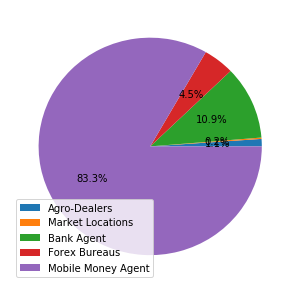

In [32]:
counts = df['access_points_percentage']
labels = df['type']
plt.figure(figsize=(5,5))
plt.pie(counts, autopct='%1.1f%%')
plt.legend(labels);

Number of services

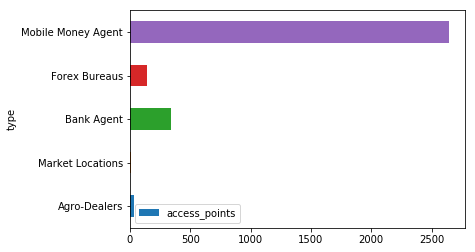

In [33]:
df.plot(x='type', y='access_points', kind='barh')

Mean distance to access points

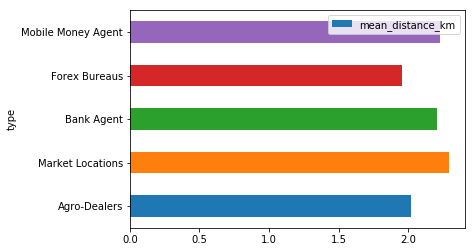

In [34]:
df.plot(x='type', y='mean_distance_km', kind='barh')

*** 

# Contextual layers analysis

## AidData 
** Total transaction value per year (chart)**

Polygon 

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326) as the_geom)
            
  SELECT transaction_year, sum(transaction_value) as total_transaction_value, transaction_currency
    FROM aiddata_transactions as a, b
   WHERE ST_Intersects(b.the_geom, a.the_geom)
GROUP BY transaction_year, transaction_currency
ORDER BY transaction_year, transaction_currency
```

Country

```sql
SELECT transaction_year, sum(transaction_value) as total_transaction_value, transaction_currency
    FROM aiddata_transactions 
   WHERE iso_a3 = 'UGA'
GROUP BY transaction_year, transaction_currency
ORDER BY transaction_year, transaction_currency
```

** Example plot with python **

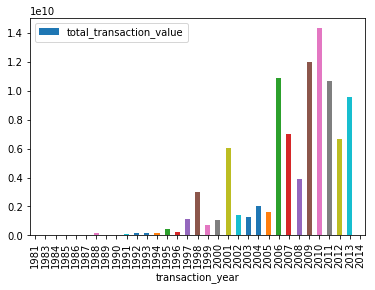

In [48]:
iso = "UGA"
query =("SELECT transaction_year, sum(transaction_value) as total_transaction_value, " 
        "transaction_currency "
        "FROM aiddata_transactions " 
        f"WHERE iso_a3 = '{iso}' "
        "GROUP BY transaction_year, transaction_currency "
        "ORDER BY transaction_year, transaction_currency "
)

account = 'ikerey'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json().get('rows')
df = pd.DataFrame.from_dict(json_normalize(data))

df.plot(x='transaction_year', y='total_transaction_value', kind='bar');

## Electrical Grid
** Number of lines and total lenth (numeric)**

Polygon 

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326) as the_geom)

SELECT iso, count(*) as total_lines, sum(length_km) as total_length_km
    FROM electrical_grid as e, b
   WHERE ST_Intersects(b.the_geom, e.the_geom)
GROUP BY iso
ORDER BY iso
```

Country

```sql
SELECT iso, count(*) as total_lines, sum(length_km) as total_length_km
    FROM electrical_grid
   WHERE iso = 'UGA'
GROUP BY iso
ORDER BY iso
```

** Example numbers with python **

In [50]:
iso = "UGA"
query =("SELECT iso, count(*) as total_lines, sum(length_km) as total_length_km "
"FROM electrical_grid "
"WHERE iso = 'UGA' "
"GROUP BY iso "
"ORDER BY iso "
)

account = 'ikerey'
urlCarto = f"https://{account}.carto.com/api/v2/sql"

sql = {"q": query}
r = requests.get(urlCarto, params=sql)

data = r.json().get('rows')
df = pd.DataFrame.from_dict(json_normalize(data))
df.head()

,iso,total_length_km,total_lines
0,UGA,28978,30161


## Movile Coverage
** Percentage area covered by GSM, 3G, and 4G (chart) **

Polygon 

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326) as the_geom)

SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g,
FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm
        FROM mobile_coverage_global_gsm as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as gsm,
      (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g
        FROM mobile_coverage_global_3g as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as a3g,
     (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g
        FROM mobile_coverage_global_4g as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as a4g,
     (SELECT ST_Area(b.the_geom) as area_tot
        FROM b 
      ) as atot
```

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA')
            
SELECT round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_gsm, round(((a3g.area_3g/atot.area_tot)*100)::numeric, 1) as area_percentage_3g, round(((a4g.area_4g/atot.area_tot)*100)::numeric, 1) as area_percentage_4g,
FROM (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_gsm
        FROM mobile_coverage_global_gsm as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as gsm,
      (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_3g
        FROM mobile_coverage_global_3g as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as a3g,
     (SELECT sum(ST_Area(ST_Intersection(m.the_geom, b.the_geom))) as area_4g
        FROM mobile_coverage_global_4g as m, b 
       WHERE ST_Intersects(m.the_geom, b.the_geom)
      ) as a4g,
     (SELECT ST_Area(b.the_geom) as area_tot
        FROM b 
      ) as atot          
```

## Urban Areas
** Percentage of Urban and Rural areas (chart) **

Polygon

```sql
WITH b as (SELECT st_setsrid(st_geomfromgeojson('
{"type":"Polygon","coordinates":[[[30.618896484375,-0.5053645409602877],[31.651611328125004,-0.5053645409602877],[31.651611328125004,0.208739772610497],[30.618896484375,0.208739772610497],[30.618896484375,-0.5053645409602877]]]}'),4326) as the_geom),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom 
             FROM urban_areas as u, b
            WHERE ST_Intersects(b.the_geom, u.the_geom))

SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as rural_population_percentage
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb
```

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA'),
     u as (SELECT ST_Intersection(u.the_geom,b.the_geom) as the_geom FROM urban_areas as u
             JOIN world_borders_hd as b
               ON ST_Intersects(b.the_geom, u.the_geom)
            WHERE b.iso_a3 = 'UGA')

SELECT round(((COALESCE(urb.pop,tot.pop)/tot.pop)*100)::numeric, 1) as urban_population_percentage, round((((tot.pop - COALESCE(urb.pop,tot.pop))/tot.pop)*100)::numeric,1) as rural_population_percentage
FROM (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, b.the_geom),1,True)).sum) as pop
        FROM population_count_2015, b 
       WHERE ST_Intersects(the_raster_webmercator, b.the_geom)
      ) as tot,
     (SELECT round((ST_SummaryStatsAgg(ST_Clip(the_raster_webmercator, u.the_geom),1,True)).sum) as pop
        FROM population_count_2015, u 
       WHERE ST_Intersects(the_raster_webmercator, u.the_geom)
      ) as urb
```

## Accessibility to Cities
** Time to reach a city (numeric) **

Polygon (Nearby)

Polygon (Area of Interest)

Country

```sql
WITH b as (SELECT the_geom FROM world_borders_hd as b 
            WHERE b.iso_a3 = 'UGA')
            
SELECT ST_SUMMARYSTATS()
FROM 'cit01701-Travel-Time-to-Major-Cities' as c, b
WHERE ST_INTERSECTS(c.the_geom, b.the_geom)
```

** Example numbers with python **

Kenya's polygon in rw api:
https://api.resourcewatch.org/v1/geostore/admin/KEN

In [54]:
geostore_id= "9c7243fa187dc4cc436b8b11a9b78c05"
slug = 'cit01701-Travel-Time-to-Major-Cities'
sql= f"SELECT ST_SUMMARYSTATS() FROM {slug}"

params={"sql": sql, "geostore": geostore_id}
url = "https://api.resourcewatch.org/v1/query"


r = requests.get(f"{url}", params)
r.json()

{'data': [{'st_summarystats': {'accessibility': {'count': 136620,
     'max': 7089,
     'mean': 5654.312889767238,
     'min': 189,
     'stdev': 1255.9418668073565,
     'sum': 772492227}}}],
 'meta': {}}